## Imports Librairies

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import joblib

## Set configs

In [6]:
# Config
TICKER = "BTC-EUR"
START = "2018-01-01"
H = 5   # horizon multi-step
SEQ_LEN = 60  # longueur de la séquence d'entrée
BATCH_SIZE = 32
EPOCHS = 30
LR = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cpu


## Data Retrieval

In [3]:
df = yf.download(TICKER, start=START)
df = df[['Close']]
df.head()

C:\Users\Fred\AppData\Local\Temp\ipykernel_1712\3029087536.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START)
[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,BTC-EUR
Date,
2018-01-01,11372.470703
2018-01-02,12421.938477
2018-01-03,12656.952148
2018-01-04,12928.228516
2018-01-05,14490.771484


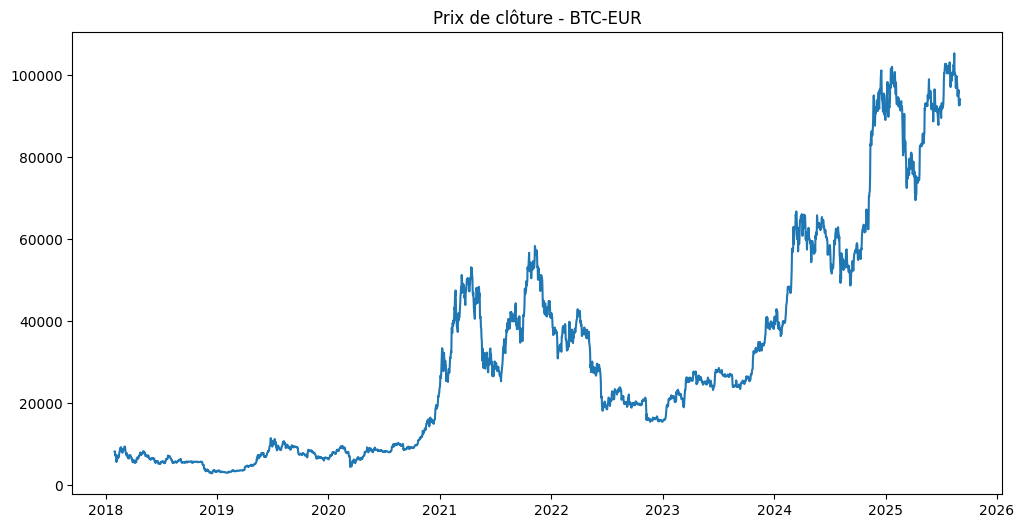

In [4]:
# Moyennes mobiles
df["ma_10"] = df["Close"].rolling(10).mean()
df["ma_30"] = df["Close"].rolling(30).mean()

# Volatilité (écart-type sur 10 jours)
df["vol_10"] = df["Close"].pct_change().rolling(10).std()

# RSI basique sur 14 jours
delta = df["Close"].diff()
gain = delta.clip(lower=0).rolling(14).mean()
loss = -delta.clip(upper=0).rolling(14).mean()
rs = gain / (loss + 1e-9)
df["rsi_14"] = 100 - 100/(1+rs)

# Supprimer les lignes avec NaN (rollings au début)
df = df.dropna()

plt.figure(figsize=(12,6))
plt.plot(df['Close'])
plt.title(f"Prix de clôture - {TICKER}")
plt.show()

## Data Preprocessing

In [8]:
feature_cols = ["Close", "ma_10", "ma_30", "vol_10", "rsi_14"]
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df[feature_cols])
y_scaled = scaler_y.fit_transform(df[["Close"]].values)  # ou diff/return si tu veux


def make_sequences(X, y, seq_len=SEQ_LEN, horizon=H):
    Xs, Ys = [], []
    for i in range(len(X) - seq_len - horizon + 1):
        Xs.append(X[i:i+seq_len])
        Ys.append(y[i+seq_len:i+seq_len+horizon].ravel())  # H valeurs à la suite
    return np.array(Xs, dtype=np.float32), np.array(Ys, dtype=np.float32)


X_seq, y_seq = make_sequences(X_scaled, y_scaled, SEQ_LEN, H)

# Split train/test chronologique
split_idx = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2167, 60, 5) (2167, 5)
(542, 60, 5) (542, 5)


## Dataset & DataLoader

In [9]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


## LSTM Model

In [10]:
class LSTMDirect(nn.Module):
    def __init__(self, input_size=X_train.shape[2], hidden_size=64, num_layers=2, horizon=H):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, horizon)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # on prend le dernier pas de la séquence
        return out

model = LSTMDirect().to(DEVICE)
criterion = nn.MSELoss()  # ou HuberLoss pour plus de robustesse
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

## Training loop

In [12]:
for epoch in range(EPOCHS):
    model.train()
    losses = []
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {np.mean(losses):.7f}")

Epoch 1/30, Loss: 0.0004043
Epoch 2/30, Loss: 0.0004143
Epoch 3/30, Loss: 0.0003981
Epoch 4/30, Loss: 0.0003848
Epoch 5/30, Loss: 0.0003771
Epoch 6/30, Loss: 0.0003494
Epoch 7/30, Loss: 0.0003507
Epoch 8/30, Loss: 0.0004085
Epoch 9/30, Loss: 0.0003513
Epoch 10/30, Loss: 0.0003795
Epoch 11/30, Loss: 0.0003222
Epoch 12/30, Loss: 0.0003279
Epoch 13/30, Loss: 0.0003459
Epoch 14/30, Loss: 0.0003588
Epoch 15/30, Loss: 0.0003318
Epoch 16/30, Loss: 0.0003172
Epoch 17/30, Loss: 0.0003448
Epoch 18/30, Loss: 0.0002982
Epoch 19/30, Loss: 0.0003213
Epoch 20/30, Loss: 0.0003254
Epoch 21/30, Loss: 0.0003111
Epoch 22/30, Loss: 0.0003146
Epoch 23/30, Loss: 0.0003223
Epoch 24/30, Loss: 0.0003241
Epoch 25/30, Loss: 0.0003013
Epoch 26/30, Loss: 0.0003064
Epoch 27/30, Loss: 0.0002951
Epoch 28/30, Loss: 0.0003124
Epoch 29/30, Loss: 0.0003398
Epoch 30/30, Loss: 0.0002984


## Predictions and evaluations

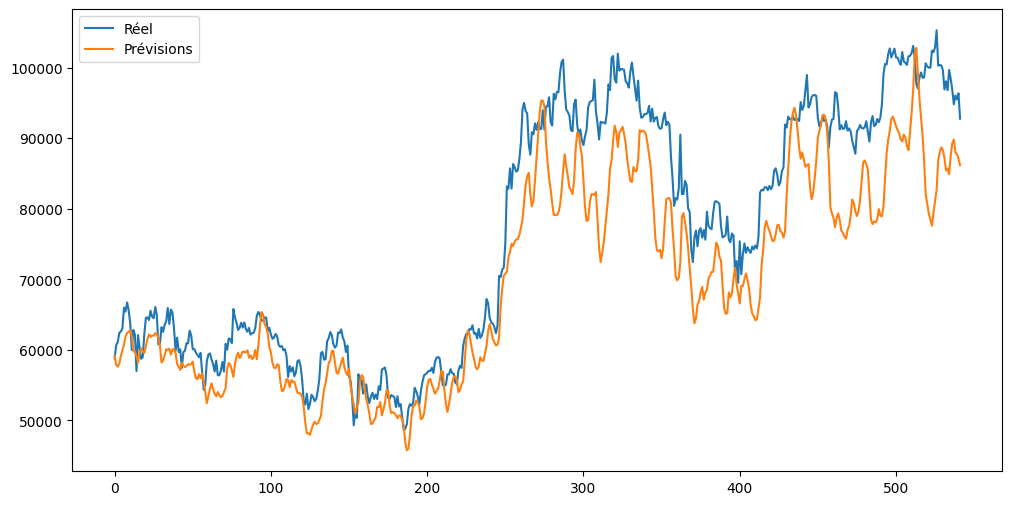

Test RMSE: 9162.9423828125
Test MAE: 7178.27734375
Test MAPE: 8.740005642175674 %


In [13]:
model.eval()
preds = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(DEVICE)
        output = model(X_batch)
        preds.append(output.cpu().numpy())

preds = np.concatenate(preds, axis=0)
preds_inv = scaler_y.inverse_transform(preds)
y_test_inv = scaler_y.inverse_transform(y_test)

# Exemple : visualiser le premier horizon
plt.figure(figsize=(12,6))
plt.plot(y_test_inv[:,0], label="Réel")
plt.plot(preds_inv[:,0], label="Prévisions")
plt.legend()
plt.show()

rmse = root_mean_squared_error(y_test_inv, preds_inv)
mae = mean_absolute_error(y_test_inv, preds_inv)
mape = mean_absolute_percentage_error(y_test_inv, preds_inv)
print("Test RMSE:", rmse)
print("Test MAE:", mae)
print("Test MAPE:", mape*100,"%")


## Predict future

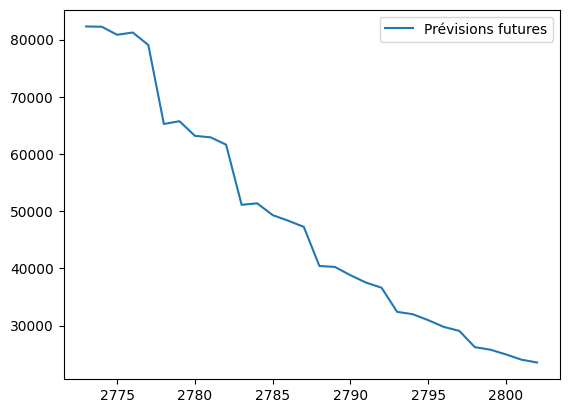

In [14]:
def predict_future(model, last_seq, n_steps, scaler_y, H=5, device=DEVICE):
    """
    Predict n_steps into the future using a multi-horizon LSTM.
    
    last_seq : np.array de forme (SEQ_LEN, n_features) -> dernière séquence connue
    n_steps  : nombre total de pas à prédire
    scaler_y : scaler pour inverser la cible
    H        : horizon du modèle (nombre de pas prédits à la fois)
    """
    model.eval()
    seq = last_seq.copy()
    predictions = []

    with torch.no_grad():
        steps = n_steps
        while steps > 0:
            input_seq = torch.tensor(seq[-SEQ_LEN:], dtype=torch.float32).unsqueeze(0).to(device)
            pred = model(input_seq).cpu().numpy().ravel()  # shape (H,)
            
            # ne garder que ce qui reste à prédire
            to_take = min(steps, H)
            predictions.extend(pred[:to_take])
            
            # réinjecter dans la séquence
            next_feat = np.zeros(seq.shape[1])
            next_feat[0] = pred[0]  # mise à jour uniquement du prix (ou target)
            seq = np.vstack([seq, next_feat])
            
            steps -= to_take

    predictions = np.array(predictions).reshape(-1, 1)
    return scaler_y.inverse_transform(predictions)


# Utilisation : prévoir les 30 prochains jours
last_seq = X_scaled[-SEQ_LEN:]
future_preds = predict_future(model, last_seq, 30, scaler_y)

plt.plot(range(len(df), len(df) + 30), future_preds, label="Prévisions futures")
plt.legend()
plt.show()


## Save Model

In [15]:
# 1) Modèle
torch.save(model.state_dict(), "btc_eur_lstm_direct.pth")

# 2) Scalers
joblib.dump(scaler_X, "scaler_X.save")
joblib.dump(scaler_y, "scaler_y.save")

print("Modèle et scalers sauvegardés !")

Modèle et scalers sauvegardés !
